# &emsp; Case 2
Jukka Holopainen, Merja Leisti, Matti Närhi <br>
Modified last 1.3.2020  <br>
Helsinki Metropolia University of Applied Sciences<br><br>
Introduction <br>

In this document we will create and train three different convolutional neural networks to classify medical images. These images are x-ray chest images which indicate either penumonia or healthy lungs. Thus we’ ll create a binary classifier.<br><br>
We are going to compare these three models and then select the best model. We target to get specifity level at least 90%.


In [1]:

%pylab inline
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import SensitivityAtSpecificity
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os




Populating the interactive namespace from numpy and matplotlib


<h1>Data</h1>
The data was color pictures varies sizes. From them about 25% was normal cases and 75% were pneumonia cases. <br> 
We split data 60-20-20 where training data got 60% of the data and validation and test data got 20% each.<br>
In preprosessing the data we suffled it and made all the pictures 150x150 sizes.

In [2]:
train_dir = '/kaggle/input/chest-xray-images-for-classification-pneumonia/pneumonia/train'
validation_dir = '/kaggle/input/chest-xray-images-for-classification-pneumonia/pneumonia/validation'
test_dir = '/kaggle/input/chest-xray-images-for-classification-pneumonia/pneumonia/test'
print(os.listdir(train_dir))
print(os.listdir(validation_dir))
print(os.listdir(test_dir))

['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']


In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255)
dev_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 64, class_mode = "binary")
dev_generator = dev_datagen.flow_from_directory(validation_dir, target_size = (150, 150), batch_size = 64, shuffle = False, class_mode = "binary")
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 64, class_mode = "binary")

Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.


<h1>Models</h1>
In our first model we decided ro make only twice Conv2D and MaxPooling2d set. After that the model will flatten the image data so that we can make it into single row of matrix. So that the model can easily prossec it in its dense network. After that because problem was binary sigmoind activation function will make so that the answer is between one and zero. Where 0 is normal and 1 is pneumonia.

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43808)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               22430208  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

As optimazer we used RMSprop and as metrics how well the neuralnetwork work we used sensitivity at specificity.

In [5]:
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = [SensitivityAtSpecificity(0.9)])

history = model.fit_generator(train_generator,  verbose = 0, epochs = 10, validation_data = dev_generator,
                             )



In [6]:
loss = history.history['loss']
val_loss = history.history['val_loss']
sens = history.history['sensitivity_at_specificity']
val_sens = history.history['val_sensitivity_at_specificity']
epochs = range(len(sens))


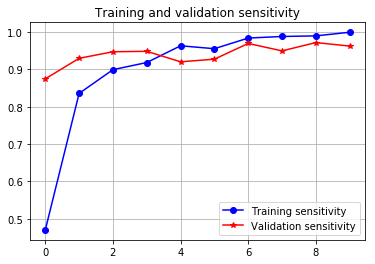

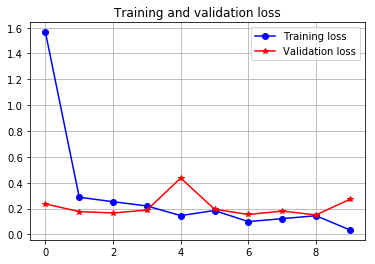

In [7]:
plot(epochs, sens, 'bo-', label = 'Training sensitivity')
plot(epochs, val_sens, 'r*-', label = 'Validation sensitivity')
title('Training and validation sensitivity')
grid()
legend()

figure()
plot(epochs, loss, 'bo-', label = 'Training loss')
plot(epochs, val_loss, 'r*-', label = 'Validation loss')
title('Training and validation loss')
grid()
legend()

show()

As we find in our diagrams the first neural network is rather good. Asboth validation and training sensitivity is about 0,95 and their loss is less than 0,2.

In [8]:
predictions = model.predict(dev_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = dev_generator.classes

class_labels = list(dev_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predictions > 0.5).T

print("Confusion matrix based on validation data: \n", cm)
print(predicted_classes[0:10])

Confusion matrix based on validation data: 
 [[258  16]
 [ 59 839]]
[0 0 0 0 0 0 0 0 0 0]


In [9]:
result = classification_report(true_classes, predictions > 0.5, target_names = class_labels)
print("Classification report based on validation data: \n", result)

Classification report based on validation data: 
               precision    recall  f1-score   support

      NORMAL       0.94      0.81      0.87       317
   PNEUMONIA       0.93      0.98      0.96       855

    accuracy                           0.94      1172
   macro avg       0.94      0.90      0.92      1172
weighted avg       0.94      0.94      0.93      1172



In [10]:
test_loss, test_sens = model.evaluate_generator(test_generator)
print("Test loss:", test_loss)
print("Test sensitivity: ", test_sens)

Test loss: 0.19032088039737
Test sensitivity:  0.9789227


In [11]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 16, class_mode = "binary")
dev_generator = dev_datagen.flow_from_directory(validation_dir, target_size = (150, 150), batch_size = 16,shuffle = False, class_mode = "binary")
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 16, class_mode = "binary")

Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.


As our next model we added four Conv2D and MaxPooling 2D. This should give us better results than the previous model. Also we had made so that the second last layer has twice as few neurons than the previous. 

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 32)       

In [13]:
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = [SensitivityAtSpecificity(0.9)])

history = model.fit_generator(train_generator, verbose = 0, epochs = 50, validation_data = dev_generator,
                             )

In [14]:
#history.history

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
sens = history.history['sensitivity_at_specificity_1']
val_sens = history.history['val_sensitivity_at_specificity_1']
epochs = range(len(sens))

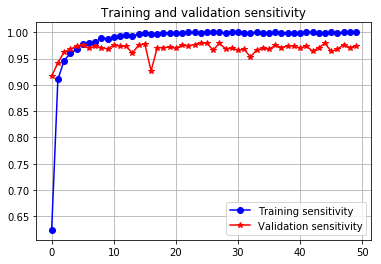

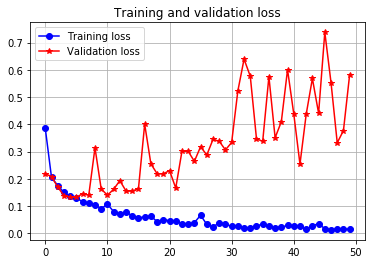

In [16]:
plot(epochs, sens, 'bo-', label = 'Training sensitivity')
plot(epochs, val_sens, 'r*-', label = 'Validation sensitivity')
title('Training and validation sensitivity')
grid()
legend()

figure()
plot(epochs, loss, 'bo-', label = 'Training loss')
plot(epochs, val_loss, 'r*-', label = 'Validation loss')
title('Training and validation loss')
grid()
legend()

show()

As we see in first graph the sensitivity for training data are close to one and while validation datas is about 0.975. Validation sensitivity stays at that value really well starting at about 10th epoch. As loss the best epoch was either 6 or 10 after that the validation loss start growing while training loss stedily decrease. 

In [17]:
predictions = model.predict_generator(dev_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = dev_generator.classes

class_labels = list(dev_generator.class_indices.keys())



cm = confusion_matrix(true_classes, predictions > 0.5).T

print("Confusion matrix based on validation data: \n", cm)

Confusion matrix based on validation data: 
 [[291  34]
 [ 26 821]]


In [18]:
result = classification_report(true_classes, predictions > 0.5, target_names = class_labels)
print("Classification report based on validation data: \n ", result)

Classification report based on validation data: 
                precision    recall  f1-score   support

      NORMAL       0.90      0.92      0.91       317
   PNEUMONIA       0.97      0.96      0.96       855

    accuracy                           0.95      1172
   macro avg       0.93      0.94      0.94      1172
weighted avg       0.95      0.95      0.95      1172



In [19]:
test_loss, test_sens = model.evaluate_generator(test_generator)
print("Test loss: ", test_loss)
print("Test sensitivity: ", test_sens)


Test loss:  0.3986340725585585
Test sensitivity:  0.9824356


In [20]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 32, class_mode = "binary")
dev_generator = dev_datagen.flow_from_directory(validation_dir, target_size = (150, 150), batch_size = 32, shuffle = False, class_mode = "binary")
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 32, class_mode = "binary")

Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.


In our third and last model we added one Conv2D and MaxPooling2D layers, and we again halved neurons in our second last layer.

In [21]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same", input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 32)       

In [22]:
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = [SensitivityAtSpecificity(0.9)])

history = model.fit_generator(train_generator, verbose = 0, epochs = 75, validation_data = dev_generator,
                             )

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
sens = history.history['sensitivity_at_specificity_2']
val_sens = history.history['val_sensitivity_at_specificity_2']
epochs = range(len(sens))

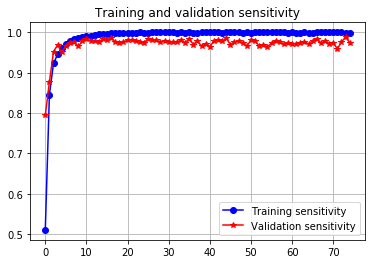

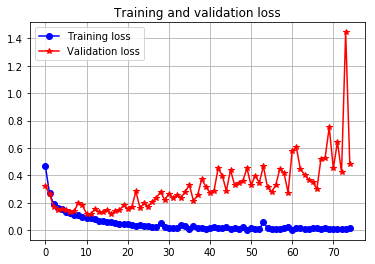

In [24]:
plot(epochs, sens, 'bo-', label = 'Training sensitivity')
plot(epochs, val_sens, 'r*-', label = 'Validation sensitivity')
title('Training and validation sensitivity')
grid()
legend()

figure()
plot(epochs, loss, 'bo-', label = 'Training loss')
plot(epochs, val_loss, 'r*-', label = 'Validation loss')
title('Training and validation loss')
grid()
legend()

show()

As we see at the first graph the training sensitivity is close to 1 while validation sensitivity is about 0.98. And that mean it is grat. Then again looking at validation loss graph, we find that it have maybe too high learning rate and its best results is in about 5th or 15th epoch. Then again trainig loss show that the neuralnetwork has good learning rate.

In [25]:
predictions = model.predict_generator(dev_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = dev_generator.classes

class_labels = list(dev_generator.class_indices.keys())



cm = confusion_matrix(true_classes, predictions > 0.5).T

print("Confusion matrix based on validation data: \n", cm)
print(predictions)

Confusion matrix based on validation data: 
 [[287  27]
 [ 30 828]]
[[1.8377501e-14]
 [6.5634574e-11]
 [1.8590676e-04]
 ...
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9999964e-01]]


In [26]:
result = classification_report(true_classes, predictions > 0.5, target_names = class_labels)
print("Classification report based on validation data: \n ", result)

Classification report based on validation data: 
                precision    recall  f1-score   support

      NORMAL       0.91      0.91      0.91       317
   PNEUMONIA       0.97      0.97      0.97       855

    accuracy                           0.95      1172
   macro avg       0.94      0.94      0.94      1172
weighted avg       0.95      0.95      0.95      1172



In [27]:
test_loss, test_sens = model.evaluate_generator(test_generator)
print("Test loss: ", test_loss)
print("Test sensitivity: ", test_sens)

Test loss:  0.3785743374918987
Test sensitivity:  0.9859485


<h1>Conculsions</h1>
As we see the 3rd model gave us the best sensitivity of ~0.99. Which tell us that the model can nearly perfectly tell which rongten picture has pneumonia case. But while the loss is ~0.38 which tell us we still should have a doctor check the rongten before giving diagnos.